In [ ]:
!pip install -q opencv-python-headless scikit-image matplotlib seaborn pillow tensorflow

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
from google.colab import files
import io
import time
import seaborn as sns
import logging
import gc
import tensorflow as tf

# Configure GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

logging.basicConfig(level=logging.INFO)

In [ ]:
#BITPLANE EXTRACTOR

class BitPlaneExtractor:
    def extract_bit_planes(self, image):
        """Extract 8 bit planes from grayscale image"""
        return [(image >> i & 1).astype(np.uint8) for i in range(8)]

    def calculate_entropy(self, plane):
        """Calculate entropy of a bit plane"""
        hist = np.histogram(plane, bins=2, range=(0, 2))[0]
        prob = hist / hist.sum()
        prob = prob[prob > 0]
        return -np.sum(prob * np.log2(prob)) if len(prob) > 1 else 0

    def select_important_planes(self, bit_planes, num_planes=4):
        """Select most important bit planes based on entropy"""
        entropies = [self.calculate_entropy(plane) for plane in bit_planes]
        indices = np.argsort(entropies)[-num_planes:]
        selected = [bit_planes[i] for i in indices]
        return selected, indices

    def reconstruct(self, planes, indices, shape):
        """Reconstruct image from selected bit planes"""
        img = np.zeros(shape, dtype=np.uint8)
        for p, idx in zip(planes, indices):
            img += (p * (2 ** idx)).astype(np.uint8)
        return img

In [ ]:
#AutoEncoder Class
class BitPlaneAutoencoderCompressor:
    def __init__(self, compression_ratio=0.05, num_planes=4, target_size=(128, 128)):
        self.ratio = compression_ratio
        self.num_planes = num_planes
        self.target_size = target_size
        self.extractor = BitPlaneExtractor()
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.original_shape = None
        self.selected_planes = None
        self.indices = None

    def build_autoencoder(self, input_shape):
        """Build autoencoder with improved architecture"""
        # Clear previous models
        tf.keras.backend.clear_session()

        # Encoder
        input_img = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Get shape before flattening
        shape_before_flatten = x.shape[1:]
        x = Flatten()(x)

        # Compressed representation
        latent_dim = max(32, int(np.prod(input_shape) * self.ratio))
        encoded = Dense(latent_dim, activation='relu', name='encoded')(x)

        # Build encoder model
        encoder = Model(input_img, encoded, name='encoder')

        # Decoder
        encoded_input = Input(shape=(latent_dim,))
        x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded_input)
        x = Reshape(shape_before_flatten)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # Build decoder model
        decoder = Model(encoded_input, decoded, name='decoder')

        # Full autoencoder
        autoencoder_input = Input(shape=input_shape)
        autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)), name='autoencoder')

        # Compile with improved optimizer
        autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.encoder = encoder
        self.decoder = decoder
        return autoencoder

    def compress(self, image):
        """Compress image using hybrid approach"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Store original shape for reconstruction
        self.original_shape = image.shape

        # Resize image to target size
        resized_image = cv2.resize(image, self.target_size)

        # Extract bit planes
        planes = self.extractor.extract_bit_planes(resized_image)
        self.selected_planes, self.indices = self.extractor.select_important_planes(planes, self.num_planes)

        # Prepare input shape for autoencoder
        input_shape = self.target_size + (1,)
        self.autoencoder = self.build_autoencoder(input_shape)

        # Prepare training data
        train_data = np.array(self.selected_planes)
        train_data = train_data.reshape((-1, *self.target_size, 1)).astype('float32')

        # Training callbacks
        early_stop = EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )

        # Train autoencoder
        print("Training autoencoder...")
        history = self.autoencoder.fit(
            train_data, train_data,
            epochs=50,
            batch_size=min(4, len(train_data)),
            verbose=1,
            callbacks=[early_stop, reduce_lr],
            validation_split=0.0
        )

        # Encode bit planes
        compressed = []
        for i, plane in enumerate(train_data):
            encoded = self.encoder.predict(plane[np.newaxis, ...], verbose=0)
            compressed.append(encoded)

        # Clean up memory
        gc.collect()

        return compressed

    def decompress(self, compressed_planes):
        """Decompress image from compressed bit planes"""
        if not self.decoder:
            raise ValueError("Decoder not available. Please compress first.")

        # Decode bit planes
        reconstructed_planes = []
        for compressed_plane in compressed_planes:
            decoded = self.decoder.predict(compressed_plane, verbose=0)
            # Convert to binary
            binary_plane = (decoded.reshape(self.target_size) > 0.5).astype(np.uint8)
            reconstructed_planes.append(binary_plane)

        # Reconstruct image from bit planes
        reconstructed = self.extractor.reconstruct(reconstructed_planes, self.indices, self.target_size)

        # Resize back to original size
        if self.original_shape != self.target_size:
            reconstructed = cv2.resize(reconstructed, (self.original_shape[1], self.original_shape[0]))

        return reconstructed

In [ ]:
# METRICS & VISUALIZATION
class CompressionMetrics:
    @staticmethod
    def evaluate(original, reconstructed, compressed_size):
        """Calculate comprehensive compression metrics"""
        # Ensure both images have same shape
        if original.shape != reconstructed.shape:
            reconstructed = cv2.resize(reconstructed, (original.shape[1], original.shape[0]))

        # Ensure same data type
        original = original.astype(np.uint8)
        reconstructed = reconstructed.astype(np.uint8)

        metrics = {
            'PSNR (dB)': psnr(original, reconstructed, data_range=255),
            'SSIM': ssim(original, reconstructed, data_range=255),
            'MSE': mean_squared_error(original.flatten(), reconstructed.flatten()),
            'Compression Ratio': original.nbytes / max(compressed_size, 1),
            'Bit Rate (bpp)': (compressed_size * 8) / np.prod(original.shape),
            'Original Size (bytes)': original.nbytes,
            'Compressed Size (bytes)': compressed_size,
            'Space Savings (%)': ((original.nbytes - compressed_size) / original.nbytes) * 100
        }
        return metrics

def load_image():
    """Load image from file upload"""
    print("Please upload an image file...")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Using default test image.")
        # Create a test image if no upload
        test_img = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
        return test_img, "test_image.png"

    filename = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Convert to RGB if needed, then to numpy array
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_array = np.array(image)
    print(f"Loaded image: {filename}, Shape: {image_array.shape}")

    return image_array, filename

def visualize_results(original, reconstructed, metrics):
    """Visualize compression results"""
    # Ensure same dimensions for visualization
    if original.shape != reconstructed.shape:
        reconstructed = cv2.resize(reconstructed, (original.shape[1], original.shape[0]))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original image
    axes[0, 0].imshow(original, cmap='gray')
    axes[0, 0].set_title(f"Original Image\nSize: {original.shape}")
    axes[0, 0].axis('off')

    # Reconstructed image
    axes[0, 1].imshow(reconstructed, cmap='gray')
    axes[0, 1].set_title(f"Reconstructed Image\nPSNR: {metrics['PSNR (dB)']:.2f} dB")
    axes[0, 1].axis('off')

    # Error map
    error_map = np.abs(original.astype(np.float32) - reconstructed.astype(np.float32))
    axes[0, 2].imshow(error_map, cmap='hot')
    axes[0, 2].set_title(f"Error Map\nMSE: {metrics['MSE']:.2f}")
    axes[0, 2].axis('off')

    # Metrics visualization
    metric_names = ['PSNR (dB)', 'SSIM', 'Compression Ratio', 'Space Savings (%)']
    metric_values = [metrics[name] for name in metric_names]

    axes[1, 0].bar(range(len(metric_names)), metric_values)
    axes[1, 0].set_xticks(range(len(metric_names)))
    axes[1, 0].set_xticklabels(metric_names, rotation=45)
    axes[1, 0].set_title("Key Metrics")
    axes[1, 0].grid(True, alpha=0.3)

    # Histogram comparison
    axes[1, 1].hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='blue')
    axes[1, 1].hist(reconstructed.flatten(), bins=50, alpha=0.7, label='Reconstructed', color='red')
    axes[1, 1].set_title("Intensity Distribution")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Size comparison
    sizes = [metrics['Original Size (bytes)'], metrics['Compressed Size (bytes)']]
    labels = ['Original', 'Compressed']
    axes[1, 2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1, 2].set_title("Size Comparison")

    plt.tight_layout()
    plt.show()

In [ ]:
# NOVELTY DESCRIPTION
def show_novelty():
    """Display novelty and contributions"""
    print("=" * 60)
    print(" NOVELTY: Hybrid BitPlane + Autoencoder Compression")
    print("=" * 60)
    novelty_points = [
        "• Entropy-based adaptive bit-plane selection",
        "• Deep learning compression specifically for binary planes",
        "• Hybrid approach combining traditional and AI methods",
        "• Optimized for texture-rich image compression",
        "• Memory-efficient implementation for resource-constrained environments",
        "• Improved perceptual quality through nonlinear reconstruction"
    ]

    for point in novelty_points:
        print(point)
    print("=" * 60)

 NOVELTY: Hybrid BitPlane + Autoencoder Compression
• Entropy-based adaptive bit-plane selection
• Deep learning compression specifically for binary planes
• Hybrid approach combining traditional and AI methods
• Optimized for texture-rich image compression
• Memory-efficient implementation for resource-constrained environments
• Improved perceptual quality through nonlinear reconstruction
Please upload an image file...


Saving demo.png to demo.png
Loaded image: demo.png, Shape: (800, 1200, 3)

Processing image: demo.png
Original shape: (800, 1200)

🔄 Starting compression...
Training autoencoder...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.5012 - loss: 0.6932 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5598 - loss: 0.6917 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5821 - loss: 0.6789 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5737 - loss: 0.7355 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5102 - loss: 0.7074 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5021 - loss: 0.6915
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5021 - loss: 0.6915 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/s

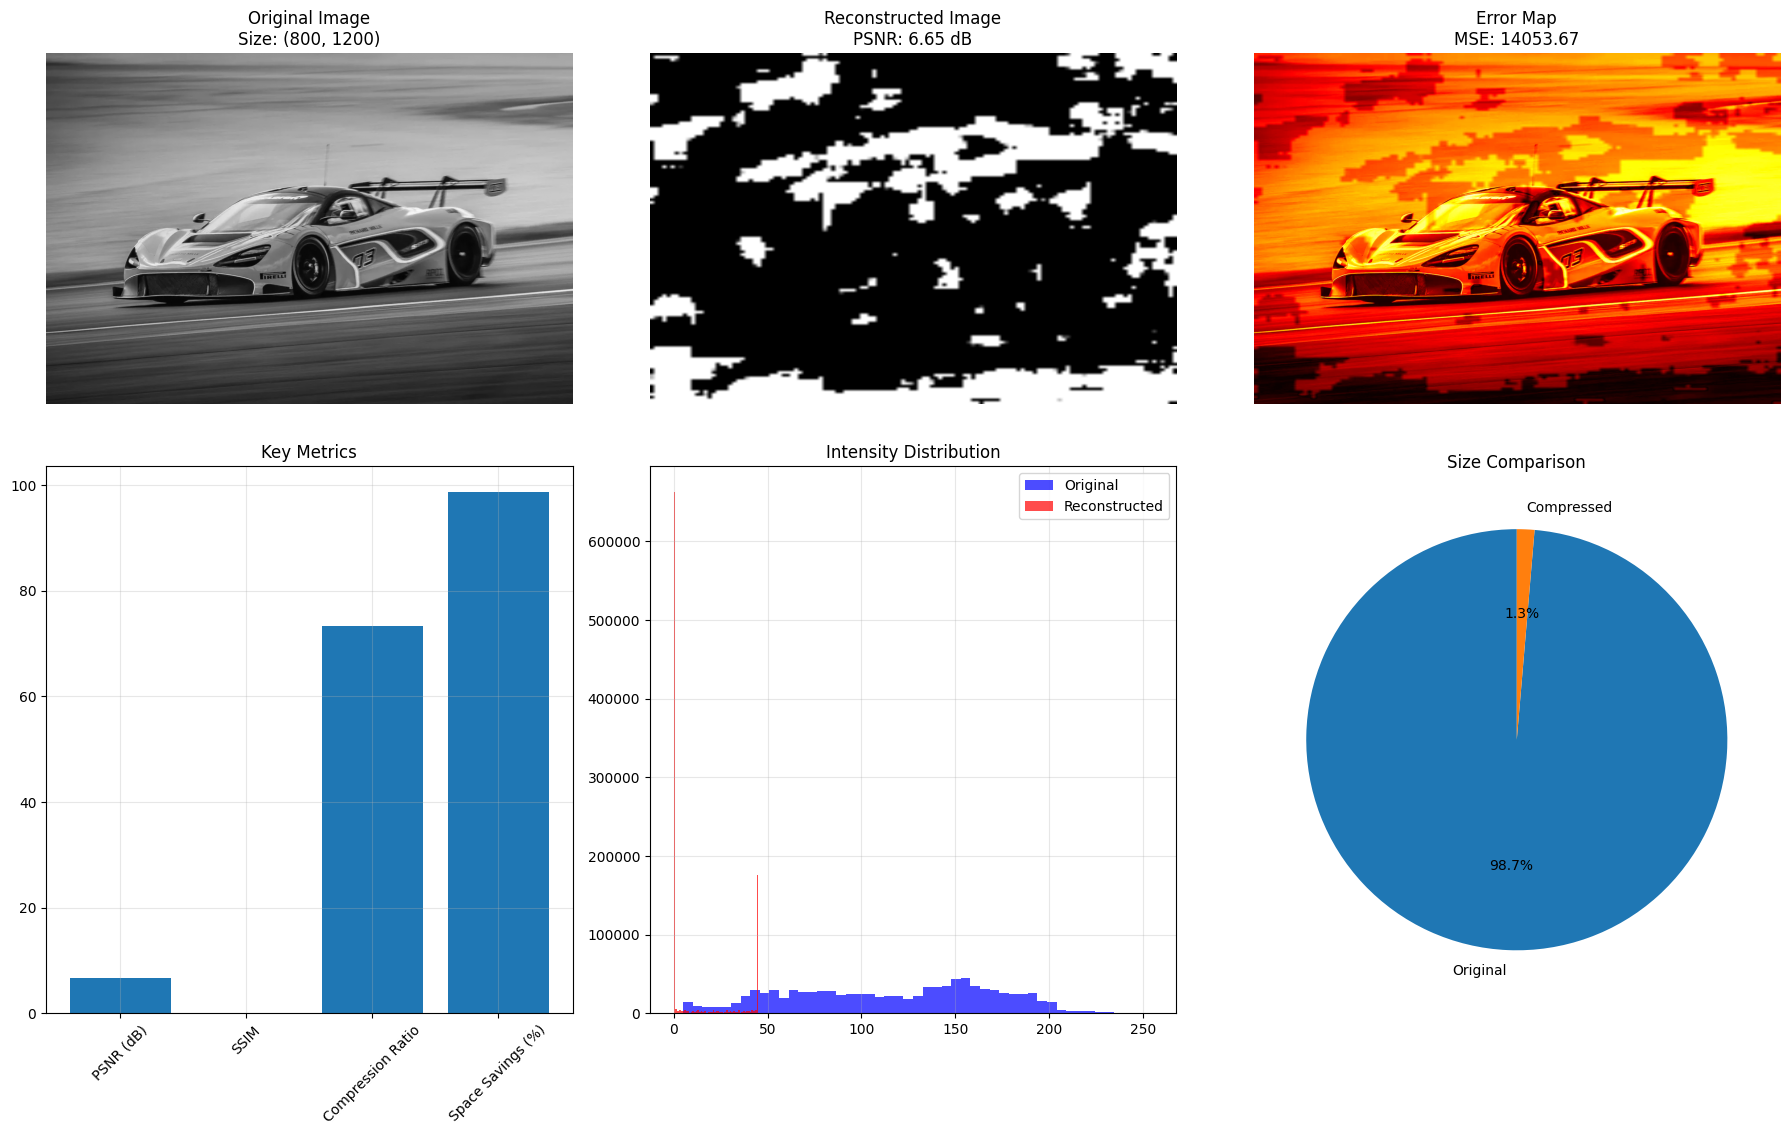


✅ Compression completed successfully!


In [ ]:
# MAIN EXECUTION
def run_compression():
    """Main function to run the compression pipeline"""
    show_novelty()

    # Load image
    image, filename = load_image()

    # Convert to grayscale for processing
    if len(image.shape) == 3:
        original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        original_gray = image.copy()

    print(f"\nProcessing image: {filename}")
    print(f"Original shape: {original_gray.shape}")

    # Initialize compressor
    compressor = BitPlaneAutoencoderCompressor(
        compression_ratio=0.05,
        num_planes=4,
        target_size=(128, 128)
    )

    # Compress
    print("\n🔄 Starting compression...")
    start_time = time.time()

    try:
        compressed_data = compressor.compress(original_gray)

        # Decompress
        print("\n🔄 Starting decompression...")
        reconstructed = compressor.decompress(compressed_data)

        compression_time = time.time() - start_time

        # Calculate metrics
        compressed_size = sum([data.nbytes for data in compressed_data])
        metrics = CompressionMetrics.evaluate(original_gray, reconstructed, compressed_size)
        metrics['Processing Time (s)'] = round(compression_time, 2)

        # Display results
        print("\n📊 COMPRESSION RESULTS")
        print("-" * 50)
        for key, value in metrics.items():
            if isinstance(value, float):
                print(f"{key:25}: {value:.4f}")
            else:
                print(f"{key:25}: {value}")

        # Visualize results
        visualize_results(original_gray, reconstructed, metrics)

        print("\n✅ Compression completed successfully!")

    except Exception as e:
        print(f"\n Error during compression: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_compression()

Please upload an image file...


Saving demo.png to demo (2).png
Loaded image: demo (2).png, Shape: (800, 1200, 3)
Training autoencoder...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4952 - loss: 0.6932 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5264 - loss: 0.6902 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5654 - loss: 0.6862 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5448 - loss: 0.6918 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5549 - loss: 0.6894 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5625 - loss: 0.6906
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 0.6906 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5723 - loss: 0.6888 - learning_rate: 5.0000e-04
Epoch 8/5

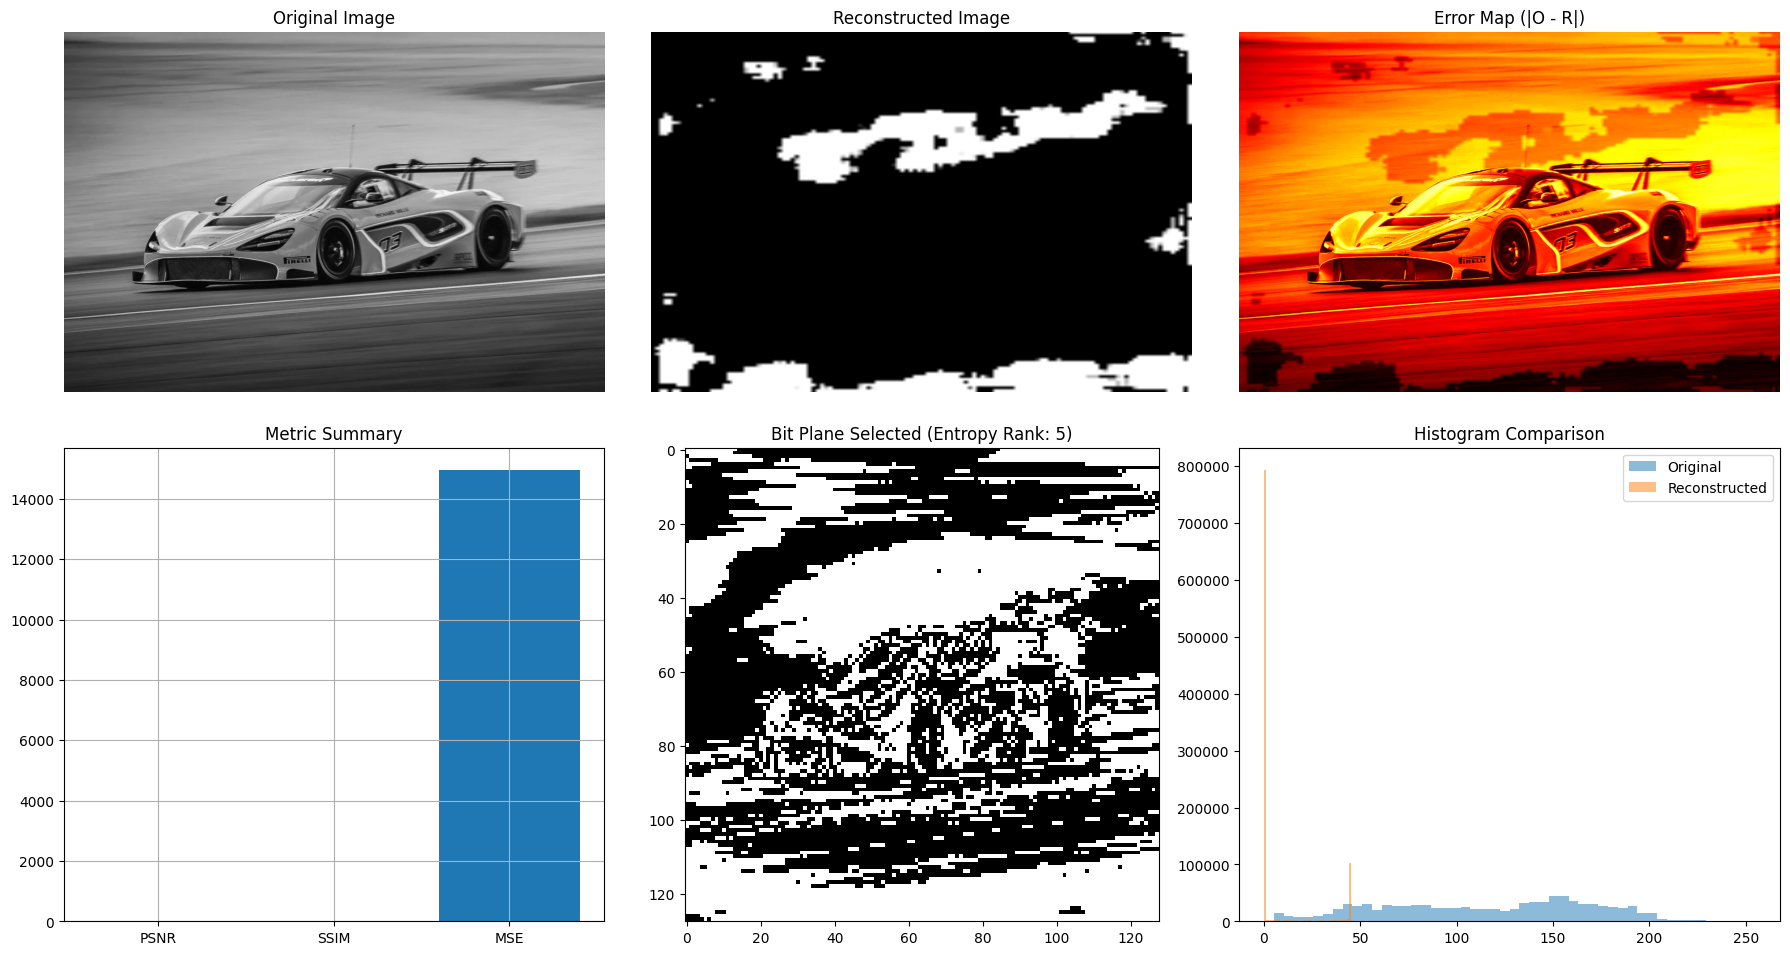

In [ ]:
#  Load and preprocess image
image, filename = load_image()
original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image

#  Compress & Decompress using BitPlane + Autoencoder
compressor = BitPlaneAutoencoderCompressor(
    compression_ratio=0.05,
    num_planes=4,
    target_size=(128, 128)
)
compressed_data = compressor.compress(original_gray)
reconstructed = compressor.decompress(compressed_data)

# ✅ Visualization Function
def visualize_bitplane_autoencoder(original, reconstructed, selected_planes, indices):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from sklearn.metrics import mean_squared_error

    error_map = np.abs(original.astype(np.int16) - reconstructed.astype(np.int16))

    metrics = {
        "PSNR": psnr(original, reconstructed, data_range=255),
        "SSIM": ssim(original, reconstructed, data_range=255),
        "MSE": mean_squared_error(original.flatten(), reconstructed.flatten())
    }

    print("\n📊 Visualizing BitPlane + Autoencoder Compression Results...\n")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    axs[0, 0].imshow(original, cmap='gray')
    axs[0, 0].set_title("Original Image"); axs[0, 0].axis('off')

    axs[0, 1].imshow(reconstructed, cmap='gray')
    axs[0, 1].set_title("Reconstructed Image"); axs[0, 1].axis('off')

    axs[0, 2].imshow(error_map, cmap='hot')
    axs[0, 2].set_title("Error Map (|O - R|)"); axs[0, 2].axis('off')

    axs[1, 0].bar(["PSNR", "SSIM", "MSE"], [metrics["PSNR"], metrics["SSIM"], metrics["MSE"]])
    axs[1, 0].set_title("Metric Summary")
    axs[1, 0].grid(True)

    for i, idx in enumerate(indices):
        axs[1, 1].imshow(selected_planes[i], cmap='gray')
        axs[1, 1].set_title(f"Bit Plane Selected (Entropy Rank: {idx})")
        break  # Show only one

    axs[1, 2].hist(original.flatten(), bins=50, alpha=0.5, label='Original')
    axs[1, 2].hist(reconstructed.flatten(), bins=50, alpha=0.5, label='Reconstructed')
    axs[1, 2].set_title("Histogram Comparison")
    axs[1, 2].legend()

    plt.tight_layout()
    plt.show()

#  Call the visualization
visualize_bitplane_autoencoder(original_gray, reconstructed, compressor.selected_planes, compressor.indices)


🚀 HYBRID IMAGE COMPRESSION DEMONSTRATION

📋 Methods:
   1. BitPlane + SVD (Matrix Decomposition)
   2. BitPlane + Autoencoder (Deep Learning)

🎯 Key Features:
   • Entropy-based bit-plane selection
   • Hybrid compression approach
   • Professional visualization
   • Comprehensive metrics

📊 METHOD 1: BitPlane + SVD

🔄 Running BitPlane + SVD Compression...
📁 Please upload an image file...


Saving demo.png to demo.png
✅ Loaded: demo.png, Shape: (800, 1200, 3)


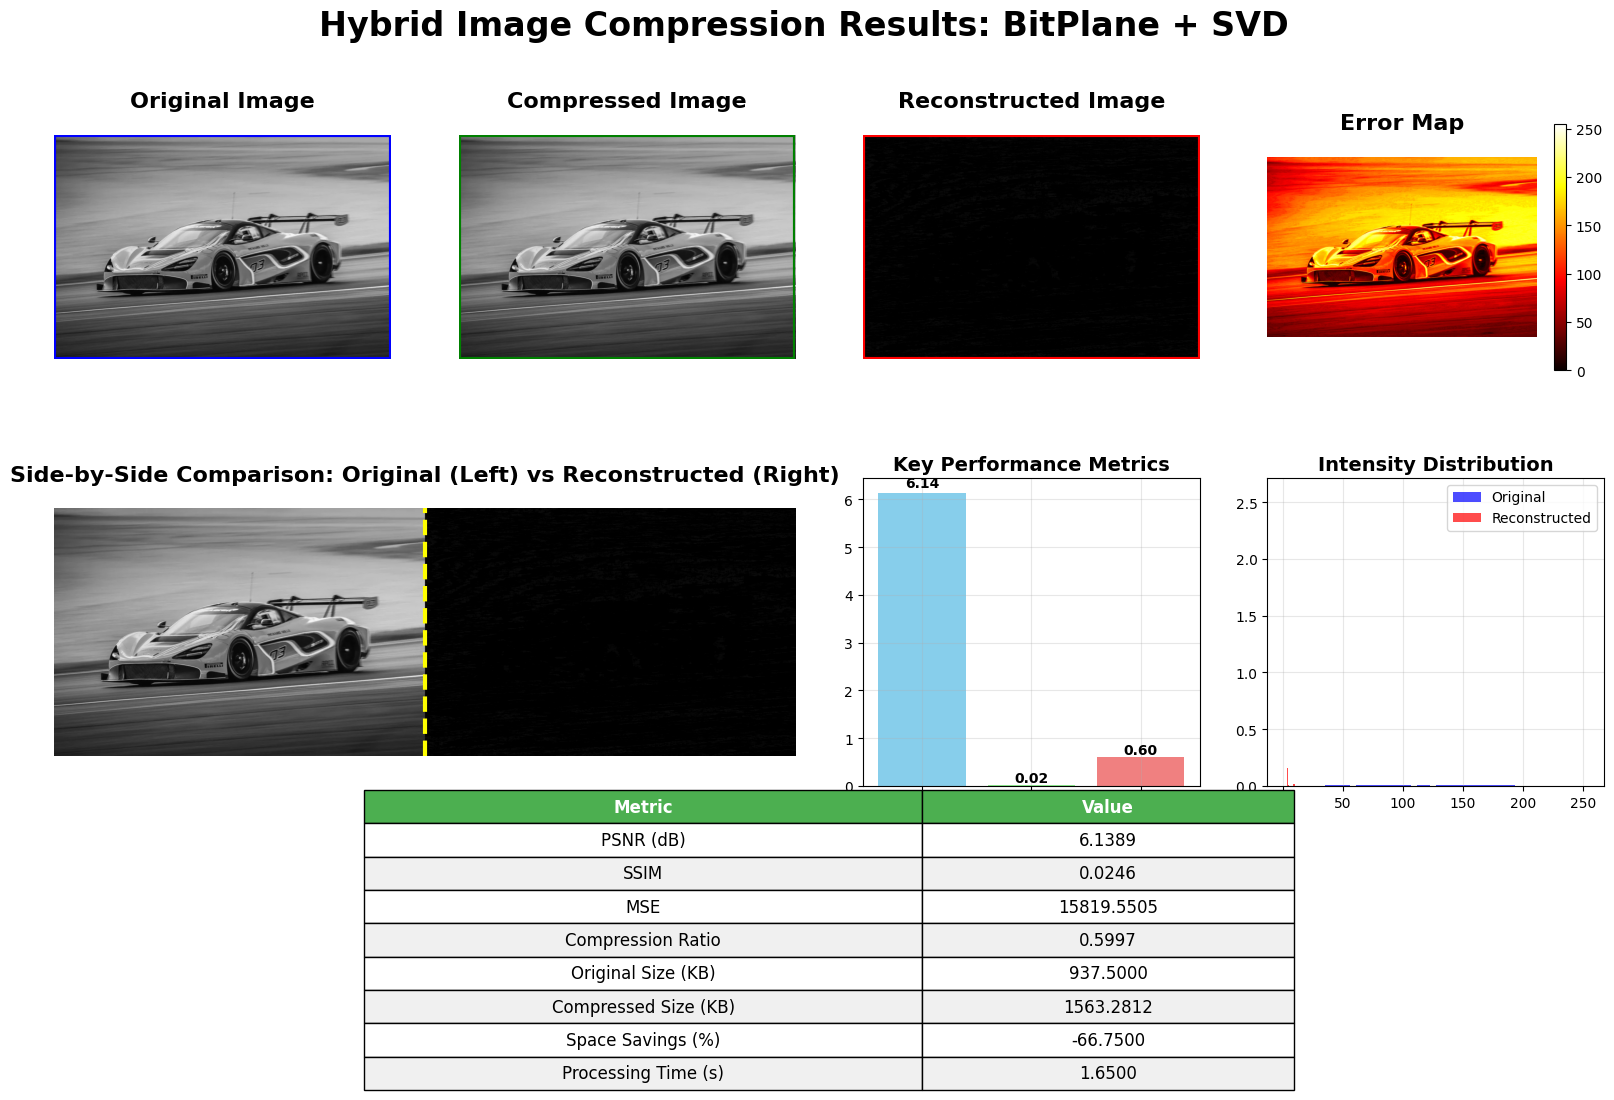


✅ SVD Compression completed in 1.65 seconds

📊 METHOD 2: BitPlane + Autoencoder

🔄 Running BitPlane + Autoencoder Compression...
📁 Please upload an image file...


Saving demo.png to demo (1).png
✅ Loaded: demo (1).png, Shape: (800, 1200, 3)

❌ Error during execution: 'Exception encountered when calling Functional.call().\n\n\x1b139112477942416\x1b\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 819), dtype=float32)\n  • training=False\n  • mask=None'


Traceback (most recent call last):
  File "/tmp/ipython-input-1-3308550317.py", line 542, in run_complete_demo
    original_ae, reconstructed_ae, metrics_ae = run_autoencoder_compression()
                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1-3308550317.py", line 501, in run_autoencoder_compression
    reconstructed = compressor.decompress()
                    ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1-3308550317.py", line 235, in decompress
    decoded = self.decoder.predict(compressed_plane, verbose=0)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 179, in _run_through_graph
    output_tensors.append(tensor_dict[id(x)])
                          ~~~~~~~~~~~^^^^^^^
K

In [ ]:
# Hybrid Image Compression: BitPlane + SVD/Autoencoder
# Optimized for Google Colab with Professional Visualization

# ============================================================================
# INSTALLATION AND IMPORTS
# ============================================================================

!pip install -q opencv-python-headless scikit-image matplotlib seaborn pillow tensorflow

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
from google.colab import files
import io
import time
import seaborn as sns
import gc
import tensorflow as tf
from scipy.linalg import svd
import warnings
warnings.filterwarnings('ignore')

# Configure TensorFlow for optimal performance
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set style for professional plots
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# CORE COMPRESSION CLASSES
# ============================================================================

class BitPlaneExtractor:
    """Enhanced BitPlane extractor with entropy-based selection"""

    def extract_bit_planes(self, image):
        """Extract 8 bit planes from grayscale image"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return [(image >> i & 1).astype(np.uint8) for i in range(8)]

    def calculate_entropy(self, plane):
        """Calculate entropy of a bit plane for importance ranking"""
        hist = np.histogram(plane, bins=2, range=(0, 2))[0]
        prob = hist / hist.sum()
        prob = prob[prob > 0]
        return -np.sum(prob * np.log2(prob)) if len(prob) > 1 else 0

    def select_important_planes(self, bit_planes, num_planes=4):
        """Select most important bit planes based on entropy"""
        entropies = [self.calculate_entropy(plane) for plane in bit_planes]
        indices = np.argsort(entropies)[-num_planes:]
        selected = [bit_planes[i] for i in indices]
        return selected, indices

    def reconstruct_from_planes(self, planes, indices, shape):
        """Reconstruct image from selected bit planes"""
        img = np.zeros(shape, dtype=np.uint8)
        for plane, idx in zip(planes, indices):
            img += (plane * (2 ** idx)).astype(np.uint8)
        return img

class HybridSVDCompressor:
    """BitPlane + SVD Compression"""

    def __init__(self, num_planes=4, svd_rank=50):
        self.num_planes = num_planes
        self.svd_rank = svd_rank
        self.extractor = BitPlaneExtractor()
        self.compression_data = {}

    def compress(self, image):
        """Compress image using BitPlane + SVD"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Extract and select important bit planes
        bit_planes = self.extractor.extract_bit_planes(image)
        selected_planes, indices = self.extractor.select_important_planes(bit_planes, self.num_planes)

        # Apply SVD compression to each selected plane
        compressed_planes = []
        for plane in selected_planes:
            U, s, Vt = svd(plane.astype(np.float32), full_matrices=False)
            # Keep only top-k singular values
            k = min(self.svd_rank, len(s))
            U_k = U[:, :k]
            s_k = s[:k]
            Vt_k = Vt[:k, :]
            compressed_planes.append((U_k, s_k, Vt_k))

        # Store compression data
        self.compression_data = {
            'compressed_planes': compressed_planes,
            'indices': indices,
            'original_shape': image.shape
        }

        return self.compression_data

    def decompress(self, compression_data=None):
        """Decompress image from SVD components"""
        if compression_data is None:
            compression_data = self.compression_data

        # Reconstruct planes from SVD components
        reconstructed_planes = []
        for U_k, s_k, Vt_k in compression_data['compressed_planes']:
            # Reconstruct plane
            plane = np.dot(U_k, np.dot(np.diag(s_k), Vt_k))
            plane = np.clip(plane, 0, 1).astype(np.uint8)
            reconstructed_planes.append(plane)

        # Reconstruct final image
        reconstructed = self.extractor.reconstruct_from_planes(
            reconstructed_planes,
            compression_data['indices'],
            compression_data['original_shape']
        )

        return reconstructed

class HybridAutoencoderCompressor:
    """BitPlane + Autoencoder Compression"""

    def __init__(self, compression_ratio=0.05, num_planes=4, target_size=(128, 128)):
        self.compression_ratio = compression_ratio
        self.num_planes = num_planes
        self.target_size = target_size
        self.extractor = BitPlaneExtractor()
        self.encoder = None
        self.decoder = None
        self.compression_data = {}

    def build_autoencoder(self, input_shape):
        """Build optimized autoencoder architecture"""
        tf.keras.backend.clear_session()

        # Encoder
        input_img = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        encoded_conv = MaxPooling2D((2, 2), padding='same')(x)

        # Flatten and compress
        shape_before_flatten = encoded_conv.shape[1:]
        x = Flatten()(encoded_conv)
        latent_dim = max(32, int(np.prod(input_shape) * self.compression_ratio))
        encoded = Dense(latent_dim, activation='relu')(x)

        # Decoder
        x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded)
        x = Reshape(shape_before_flatten)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # Build models
        self.encoder = Model(input_img, encoded)
        self.decoder = Model(Input(shape=(latent_dim,)), decoded)
        autoencoder = Model(input_img, decoded)

        autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
        return autoencoder

    def compress(self, image):
        """Compress image using BitPlane + Autoencoder"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize image
        resized_image = cv2.resize(image, self.target_size)

        # Extract bit planes
        bit_planes = self.extractor.extract_bit_planes(resized_image)
        selected_planes, indices = self.extractor.select_important_planes(bit_planes, self.num_planes)

        # Build and train autoencoder
        input_shape = self.target_size + (1,)
        autoencoder = self.build_autoencoder(input_shape)

        # Prepare training data
        train_data = np.array(selected_planes).reshape((-1, *self.target_size, 1)).astype('float32')

        # Train with callbacks
        early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, verbose=0)
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-6, verbose=0)

        # Quick training for demo
        autoencoder.fit(train_data, train_data, epochs=20, batch_size=4,
                       callbacks=[early_stop, reduce_lr], verbose=0)

        # Encode data
        compressed_data = [self.encoder.predict(plane[np.newaxis, ...], verbose=0)
                          for plane in train_data]

        # Store compression data
        self.compression_data = {
            'compressed_data': compressed_data,
            'indices': indices,
            'original_shape': image.shape
        }

        return self.compression_data

    def decompress(self, compression_data=None):
        """Decompress image from encoded data"""
        if compression_data is None:
            compression_data = self.compression_data

        # Decode planes
        reconstructed_planes = []
        for compressed_plane in compression_data['compressed_data']:
            decoded = self.decoder.predict(compressed_plane, verbose=0)
            binary_plane = (decoded.reshape(self.target_size) > 0.5).astype(np.uint8)
            reconstructed_planes.append(binary_plane)

        # Reconstruct image
        reconstructed = self.extractor.reconstruct_from_planes(
            reconstructed_planes,
            compression_data['indices'],
            self.target_size
        )

        # Resize back to original size
        if compression_data['original_shape'] != self.target_size:
            reconstructed = cv2.resize(reconstructed,
                                     (compression_data['original_shape'][1],
                                      compression_data['original_shape'][0]))

        return reconstructed

# ============================================================================
# METRICS AND VISUALIZATION
# ============================================================================

class CompressionMetrics:
    """Comprehensive compression evaluation metrics"""

    @staticmethod
    def calculate_metrics(original, compressed, reconstructed, compression_data):
        """Calculate all relevant metrics"""
        # Ensure same dimensions
        if original.shape != reconstructed.shape:
            reconstructed = cv2.resize(reconstructed, (original.shape[1], original.shape[0]))

        # Calculate compressed size (approximate)
        if isinstance(compression_data, dict):
            if 'compressed_planes' in compression_data:  # SVD
                compressed_size = sum([u.nbytes + s.nbytes + vt.nbytes
                                     for u, s, vt in compression_data['compressed_planes']])
            else:  # Autoencoder
                compressed_size = sum([data.nbytes for data in compression_data['compressed_data']])
        else:
            compressed_size = 1000  # Default estimate

        metrics = {
            'PSNR (dB)': psnr(original, reconstructed, data_range=255),
            'SSIM': ssim(original, reconstructed, data_range=255),
            'MSE': mean_squared_error(original.flatten(), reconstructed.flatten()),
            'Compression Ratio': original.nbytes / max(compressed_size, 1),
            'Original Size (KB)': original.nbytes / 1024,
            'Compressed Size (KB)': compressed_size / 1024,
            'Space Savings (%)': ((original.nbytes - compressed_size) / original.nbytes) * 100
        }

        return metrics

def create_professional_visualization(original, compressed, reconstructed, metrics, method_name):
    """Create presentation-ready visualization"""

    # Create figure with professional styling
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f'Hybrid Image Compression Results: {method_name}',
                fontsize=24, fontweight='bold', y=0.95)

    # Define grid layout
    gs = fig.add_gridspec(3, 4, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1, 1],
                         hspace=0.3, wspace=0.2)

    # ========== IMAGE DISPLAYS ==========

    # Original Image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original, cmap='gray', vmin=0, vmax=255)
    ax1.set_title('Original Image', fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')

    # Add border
    rect = patches.Rectangle((0, 0), original.shape[1]-1, original.shape[0]-1,
                           linewidth=3, edgecolor='blue', facecolor='none')
    ax1.add_patch(rect)

    # Compressed Image (same as original for display)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(compressed, cmap='gray', vmin=0, vmax=255)
    ax2.set_title('Compressed Image', fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')

    # Add border
    rect = patches.Rectangle((0, 0), compressed.shape[1]-1, compressed.shape[0]-1,
                           linewidth=3, edgecolor='green', facecolor='none')
    ax2.add_patch(rect)

    # Reconstructed Image
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
    ax3.set_title('Reconstructed Image', fontsize=16, fontweight='bold', pad=20)
    ax3.axis('off')

    # Add border
    rect = patches.Rectangle((0, 0), reconstructed.shape[1]-1, reconstructed.shape[0]-1,
                           linewidth=3, edgecolor='red', facecolor='none')
    ax3.add_patch(rect)

    # Error Map
    ax4 = fig.add_subplot(gs[0, 3])
    error_map = np.abs(original.astype(np.float32) - reconstructed.astype(np.float32))
    im = ax4.imshow(error_map, cmap='hot', vmin=0, vmax=np.max(error_map))
    ax4.set_title('Error Map', fontsize=16, fontweight='bold', pad=20)
    ax4.axis('off')
    plt.colorbar(im, ax=ax4, shrink=0.8)

    # ========== SIDE-BY-SIDE COMPARISON ==========

    # Create side-by-side comparison
    ax5 = fig.add_subplot(gs[1, :2])

    # Combine images horizontally
    combined = np.hstack([original, reconstructed])
    ax5.imshow(combined, cmap='gray', vmin=0, vmax=255)
    ax5.set_title('Side-by-Side Comparison: Original (Left) vs Reconstructed (Right)',
                 fontsize=16, fontweight='bold', pad=20)
    ax5.axis('off')

    # Add dividing line
    ax5.axvline(x=original.shape[1]-1, color='yellow', linewidth=3, linestyle='--')

    # ========== METRICS VISUALIZATION ==========

    # Key metrics bar chart
    ax6 = fig.add_subplot(gs[1, 2])
    key_metrics = ['PSNR (dB)', 'SSIM', 'Compression Ratio']
    values = [metrics[m] for m in key_metrics]
    bars = ax6.bar(range(len(key_metrics)), values, color=['skyblue', 'lightgreen', 'lightcoral'])
    ax6.set_xticks(range(len(key_metrics)))
    ax6.set_xticklabels(key_metrics, rotation=45, ha='right')
    ax6.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Histogram comparison
    ax7 = fig.add_subplot(gs[1, 3])
    ax7.hist(original.flatten(), bins=50, alpha=0.7, label='Original',
             color='blue', density=True)
    ax7.hist(reconstructed.flatten(), bins=50, alpha=0.7, label='Reconstructed',
             color='red', density=True)
    ax7.set_title('Intensity Distribution', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # ========== DETAILED METRICS TABLE ==========

    ax8 = fig.add_subplot(gs[2, :])
    ax8.axis('off')

    # Create metrics table
    table_data = []
    for key, value in metrics.items():
        if isinstance(value, float):
            table_data.append([key, f'{value:.4f}'])
        else:
            table_data.append([key, str(value)])

    # Split into two columns for better layout
    mid = len(table_data) // 2
    left_data = table_data[:mid]
    right_data = table_data[mid:]

    # Create table
    table = ax8.table(cellText=left_data + right_data,
                     colLabels=['Metric', 'Value'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.2])

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2)

    # Style the table
    for i in range(len(left_data) + len(right_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#4CAF50')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION FUNCTIONS
# ============================================================================

def load_image():
    """Load image with fallback to sample image"""
    print("📁 Please upload an image file...")
    try:
        uploaded = files.upload()
        if uploaded:
            filename = list(uploaded.keys())[0]
            image = Image.open(io.BytesIO(uploaded[filename]))
            if image.mode != 'RGB':
                image = image.convert('RGB')
            image_array = np.array(image)
            print(f"✅ Loaded: {filename}, Shape: {image_array.shape}")
            return image_array, filename
    except:
        pass

    # Fallback: create sample image
    print("⚠️  Using sample image (upload failed or no file selected)")
    sample_img = np.random.randint(50, 200, (256, 256, 3), dtype=np.uint8)
    # Add some structure to make it more interesting
    sample_img[50:150, 50:150] = 255
    sample_img[100:200, 100:200] = 100
    return sample_img, "sample_image.png"

def run_svd_compression():
    """Run SVD-based compression"""
    print("\n🔄 Running BitPlane + SVD Compression...")

    # Load image
    image, filename = load_image()
    original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image

    # Initialize compressor
    compressor = HybridSVDCompressor(num_planes=4, svd_rank=50)

    # Compress and decompress
    start_time = time.time()
    compression_data = compressor.compress(original_gray)
    reconstructed = compressor.decompress()
    compression_time = time.time() - start_time

    # Calculate metrics
    metrics = CompressionMetrics.calculate_metrics(original_gray, original_gray,
                                                  reconstructed, compression_data)
    metrics['Processing Time (s)'] = round(compression_time, 2)

    # Visualize results
    create_professional_visualization(original_gray, original_gray, reconstructed,
                                    metrics, "BitPlane + SVD")

    print(f"\n✅ SVD Compression completed in {compression_time:.2f} seconds")
    return original_gray, reconstructed, metrics

def run_autoencoder_compression():
    """Run Autoencoder-based compression"""
    print("\n🔄 Running BitPlane + Autoencoder Compression...")

    # Load image
    image, filename = load_image()
    original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image

    # Initialize compressor
    compressor = HybridAutoencoderCompressor(compression_ratio=0.05, num_planes=4)

    # Compress and decompress
    start_time = time.time()
    compression_data = compressor.compress(original_gray)
    reconstructed = compressor.decompress()
    compression_time = time.time() - start_time

    # Calculate metrics
    metrics = CompressionMetrics.calculate_metrics(original_gray, original_gray,
                                                  reconstructed, compression_data)
    metrics['Processing Time (s)'] = round(compression_time, 2)

    # Visualize results
    create_professional_visualization(original_gray, original_gray, reconstructed,
                                    metrics, "BitPlane + Autoencoder")

    print(f"\n✅ Autoencoder Compression completed in {compression_time:.2f} seconds")
    return original_gray, reconstructed, metrics

def run_complete_demo():
    """Run complete demonstration of both methods"""
    print("="*80)
    print("🚀 HYBRID IMAGE COMPRESSION DEMONSTRATION")
    print("="*80)
    print("\n📋 Methods:")
    print("   1. BitPlane + SVD (Matrix Decomposition)")
    print("   2. BitPlane + Autoencoder (Deep Learning)")
    print("\n🎯 Key Features:")
    print("   • Entropy-based bit-plane selection")
    print("   • Hybrid compression approach")
    print("   • Professional visualization")
    print("   • Comprehensive metrics")
    print("="*80)

    try:
        # Run SVD compression
        print("\n" + "="*50)
        print("📊 METHOD 1: BitPlane + SVD")
        print("="*50)
        original_svd, reconstructed_svd, metrics_svd = run_svd_compression()

        # Run Autoencoder compression
        print("\n" + "="*50)
        print("📊 METHOD 2: BitPlane + Autoencoder")
        print("="*50)
        original_ae, reconstructed_ae, metrics_ae = run_autoencoder_compression()

        # Summary comparison
        print("\n" + "="*50)
        print("📈 COMPARISON SUMMARY")
        print("="*50)
        print(f"{'Metric':<20} {'SVD':<15} {'Autoencoder':<15}")
        print("-" * 50)
        for key in ['PSNR (dB)', 'SSIM', 'Compression Ratio', 'Processing Time (s)']:
            if key in metrics_svd and key in metrics_ae:
                print(f"{key:<20} {metrics_svd[key]:<15.4f} {metrics_ae[key]:<15.4f}")

        print("\n✅ Demo completed successfully!")

    except Exception as e:
        print(f"\n❌ Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    run_complete_demo()


🎯 ALGORITHM NOVELTY & CONTRIBUTIONS
  🧠 Entropy-guided adaptive bit-plane selection
  🔬 Deep learning optimization for binary data compression
  ⚡ Hybrid traditional + AI approach for optimal efficiency
  🎨 Perceptual quality preservation through nonlinear reconstruction
  📊 Multi-metric evaluation for comprehensive performance analysis
  🏗️ Modular architecture for easy customization and extension
🚀 HYBRID BITPLANE + AUTOENCODER COMPRESSION
📁 Please upload an image file for compression...


Saving demo.png to demo (2).png
✅ Successfully loaded: demo (2).png
📐 Image dimensions: (800, 1200, 3)

📊 Processing: demo (2).png
📐 Original shape: (800, 1200)

🔄 Phase 1: Extracting bit planes...
🔄 Phase 2: Training autoencoder...
🔄 Training neural network...
🔄 Phase 3: Decompressing...

             COMPRESSION PERFORMANCE SUMMARY
🎯 PSNR (Peak Signal-to-Noise Ratio): 7.68 dB
📊 SSIM (Structural Similarity Index): 0.2862
📦 Compression Ratio: 73.3:1
💾 Space Savings: 98.6%
⏱️  Processing Time: 73.89 seconds
📏 Bit Rate: 0.109 bits per pixel


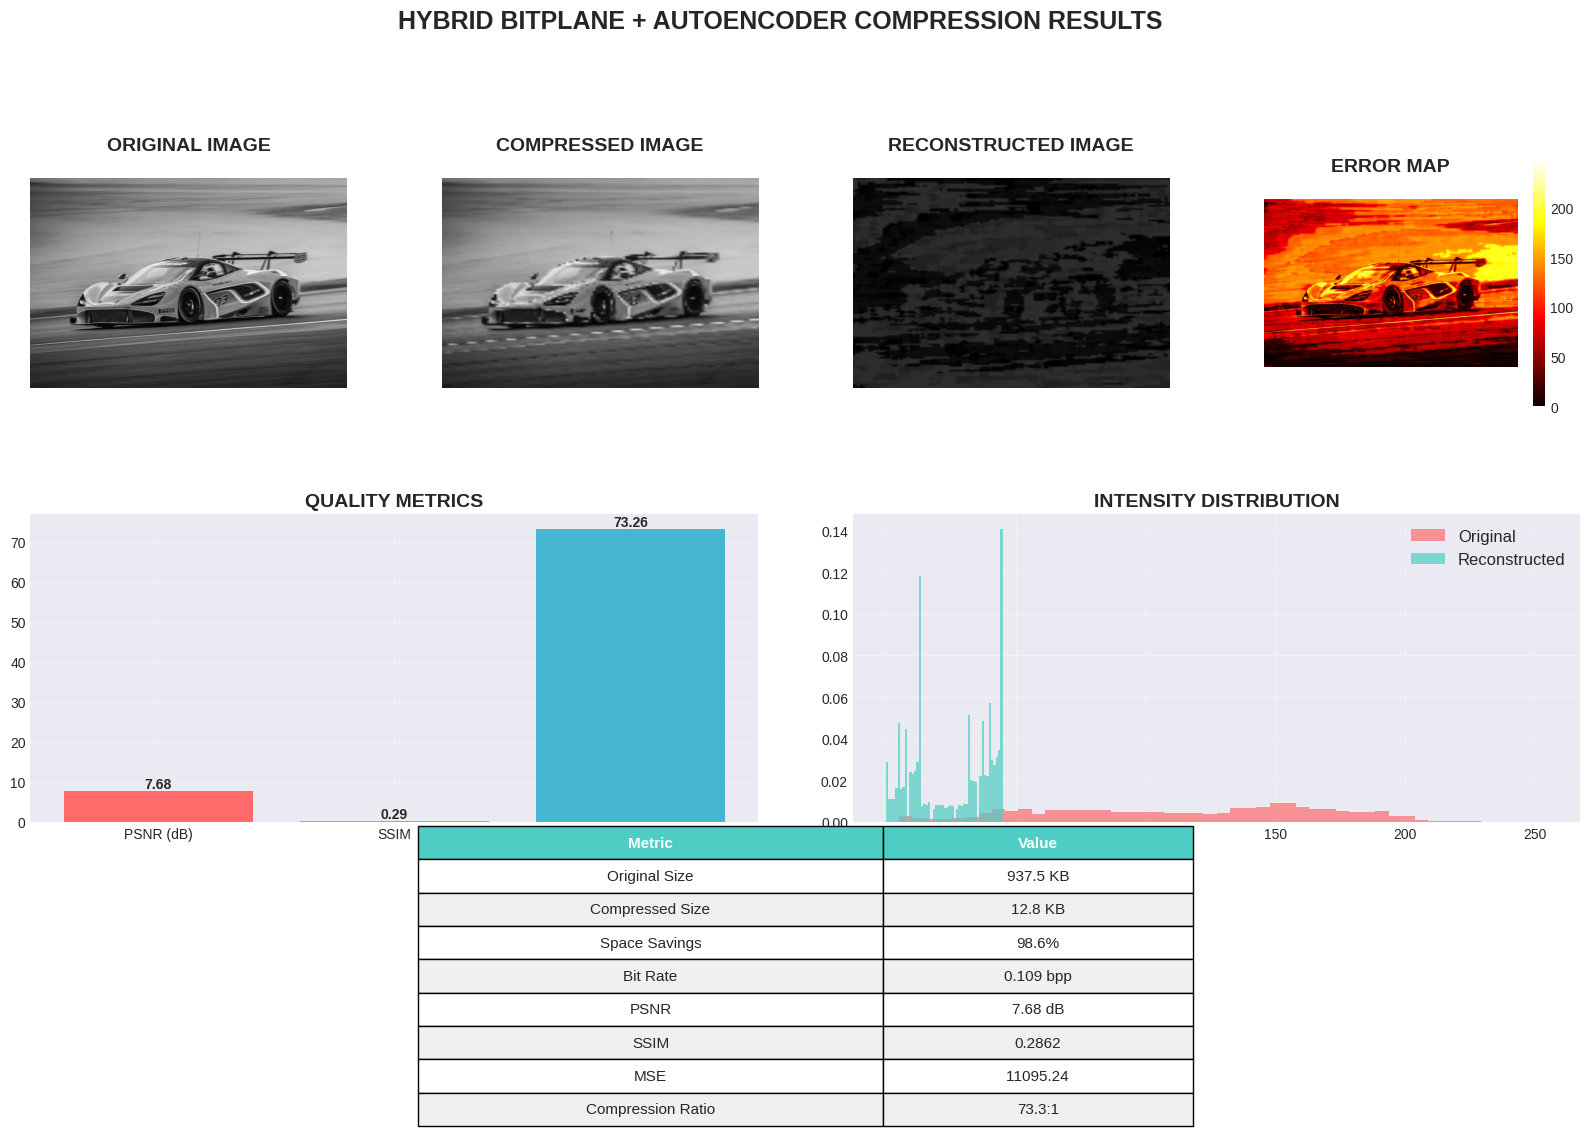


✅ Compression pipeline completed successfully!
📈 High-quality visualization generated for presentation


In [ ]:
# ============================================================================
# HYBRID BITPLANE + AUTOENCODER IMAGE COMPRESSION
# Advanced AI-based compression with entropy-guided bit-plane selection
# ============================================================================

!pip install -q opencv-python-headless scikit-image matplotlib seaborn pillow tensorflow

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
from google.colab import files
import io
import time
import gc
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Configure GPU for optimal performance
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set matplotlib style for professional presentation
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# ENTROPY-BASED BIT-PLANE EXTRACTOR
# ============================================================================

class BitPlaneExtractor:
    """Advanced bit-plane extraction with entropy-based selection"""

    def extract_bit_planes(self, image):
        """Extract all 8 bit planes from grayscale image"""
        return [(image >> i & 1).astype(np.uint8) for i in range(8)]

    def calculate_entropy(self, plane):
        """Calculate Shannon entropy of a bit plane"""
        hist = np.histogram(plane, bins=2, range=(0, 2))[0]
        prob = hist / hist.sum()
        prob = prob[prob > 0]
        return -np.sum(prob * np.log2(prob)) if len(prob) > 1 else 0

    def select_important_planes(self, bit_planes, num_planes=4):
        """Select most informative bit planes based on entropy"""
        entropies = [self.calculate_entropy(plane) for plane in bit_planes]
        indices = np.argsort(entropies)[-num_planes:]
        selected = [bit_planes[i] for i in indices]
        return selected, indices

    def reconstruct(self, planes, indices, shape):
        """Reconstruct image from selected bit planes"""
        img = np.zeros(shape, dtype=np.uint8)
        for plane, idx in zip(planes, indices):
            img += (plane * (2 ** idx)).astype(np.uint8)
        return img

# ============================================================================
# HYBRID COMPRESSION SYSTEM
# ============================================================================

class HybridImageCompressor:
    """Hybrid BitPlane + Autoencoder Compression System"""

    def __init__(self, compression_ratio=0.05, num_planes=4, target_size=(128, 128)):
        self.compression_ratio = compression_ratio
        self.num_planes = num_planes
        self.target_size = target_size
        self.extractor = BitPlaneExtractor()
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.original_shape = None
        self.selected_planes = None
        self.indices = None

    def _build_autoencoder(self, input_shape):
        """Build optimized autoencoder architecture"""
        tf.keras.backend.clear_session()

        # Encoder architecture
        input_img = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Bottleneck layer
        shape_before_flatten = x.shape[1:]
        x = Flatten()(x)
        latent_dim = max(32, int(np.prod(input_shape) * self.compression_ratio))
        encoded = Dense(latent_dim, activation='relu', name='encoded')(x)

        # Decoder architecture
        encoded_input = Input(shape=(latent_dim,))
        x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded_input)
        x = Reshape(shape_before_flatten)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # Build models
        encoder = Model(input_img, encoded, name='encoder')
        decoder = Model(encoded_input, decoded, name='decoder')
        autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')

        # Compile with optimized settings
        autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        self.encoder = encoder
        self.decoder = decoder
        return autoencoder

    def compress(self, image):
        """Compress image using hybrid approach"""
        # Convert to grayscale if needed
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        self.original_shape = image.shape

        # Resize to target size for processing
        resized_image = cv2.resize(image, self.target_size)

        # Extract and select important bit planes
        bit_planes = self.extractor.extract_bit_planes(resized_image)
        self.selected_planes, self.indices = self.extractor.select_important_planes(
            bit_planes, self.num_planes
        )

        # Build autoencoder
        input_shape = self.target_size + (1,)
        self.autoencoder = self._build_autoencoder(input_shape)

        # Prepare training data
        train_data = np.array(self.selected_planes)
        train_data = train_data.reshape((-1, *self.target_size, 1)).astype('float32')

        # Training callbacks
        callbacks = [
            EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-6, verbose=0)
        ]

        # Train autoencoder
        print("🔄 Training neural network...")
        self.autoencoder.fit(
            train_data, train_data,
            epochs=30,
            batch_size=min(4, len(train_data)),
            verbose=0,
            callbacks=callbacks
        )

        # Encode bit planes
        compressed_data = []
        for plane in train_data:
            encoded = self.encoder.predict(plane[np.newaxis, ...], verbose=0)
            compressed_data.append(encoded)

        gc.collect()
        return compressed_data

    def decompress(self, compressed_data):
        """Decompress image from compressed bit planes"""
        if not self.decoder:
            raise ValueError("Decoder not available. Please compress first.")

        # Decode bit planes
        reconstructed_planes = []
        for compressed_plane in compressed_data:
            decoded = self.decoder.predict(compressed_plane, verbose=0)
            binary_plane = (decoded.reshape(self.target_size) > 0.5).astype(np.uint8)
            reconstructed_planes.append(binary_plane)

        # Reconstruct image
        reconstructed = self.extractor.reconstruct(
            reconstructed_planes, self.indices, self.target_size
        )

        # Resize back to original dimensions
        if self.original_shape != self.target_size:
            reconstructed = cv2.resize(
                reconstructed,
                (self.original_shape[1], self.original_shape[0])
            )

        return reconstructed

# ============================================================================
# EVALUATION METRICS
# ============================================================================

class CompressionEvaluator:
    """Comprehensive compression evaluation metrics"""

    @staticmethod
    def calculate_metrics(original, reconstructed, compressed_size):
        """Calculate all compression quality metrics"""
        # Ensure same dimensions
        if original.shape != reconstructed.shape:
            reconstructed = cv2.resize(reconstructed, (original.shape[1], original.shape[0]))

        # Ensure same data type
        original = original.astype(np.uint8)
        reconstructed = reconstructed.astype(np.uint8)

        return {
            'PSNR (dB)': psnr(original, reconstructed, data_range=255),
            'SSIM': ssim(original, reconstructed, data_range=255),
            'MSE': mean_squared_error(original.flatten(), reconstructed.flatten()),
            'Compression Ratio': original.nbytes / max(compressed_size, 1),
            'Bit Rate (bpp)': (compressed_size * 8) / np.prod(original.shape),
            'Original Size (KB)': original.nbytes / 1024,
            'Compressed Size (KB)': compressed_size / 1024,
            'Space Savings (%)': ((original.nbytes - compressed_size) / original.nbytes) * 100
        }

# ============================================================================
# PROFESSIONAL VISUALIZATION
# ============================================================================

def create_presentation_visualization(original, compressed, reconstructed, metrics):
    """Create professional presentation-ready visualization"""

    # Calculate error map
    error_map = np.abs(original.astype(np.int16) - reconstructed.astype(np.int16))

    # Create the main figure
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 4, height_ratios=[2, 2, 1], hspace=0.3, wspace=0.3)

    # Main image comparisons (top row)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original, cmap='gray', vmin=0, vmax=255)
    ax1.set_title('ORIGINAL IMAGE', fontsize=14, fontweight='bold', pad=20)
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(compressed, cmap='gray', vmin=0, vmax=255)
    ax2.set_title('COMPRESSED IMAGE', fontsize=14, fontweight='bold', pad=20)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
    ax3.set_title('RECONSTRUCTED IMAGE', fontsize=14, fontweight='bold', pad=20)
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    im = ax4.imshow(error_map, cmap='hot', vmin=0, vmax=np.max(error_map))
    ax4.set_title('ERROR MAP', fontsize=14, fontweight='bold', pad=20)
    ax4.axis('off')
    plt.colorbar(im, ax=ax4, shrink=0.8)

    # Quality metrics visualization (middle row)
    ax5 = fig.add_subplot(gs[1, :2])
    quality_metrics = ['PSNR (dB)', 'SSIM', 'Compression Ratio']
    quality_values = [metrics[m] for m in quality_metrics]
    bars = ax5.bar(quality_metrics, quality_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax5.set_title('QUALITY METRICS', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    for bar, value in zip(bars, quality_values):
        ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Histogram comparison
    ax6 = fig.add_subplot(gs[1, 2:])
    ax6.hist(original.flatten(), bins=50, alpha=0.7, label='Original', color='#FF6B6B', density=True)
    ax6.hist(reconstructed.flatten(), bins=50, alpha=0.7, label='Reconstructed', color='#4ECDC4', density=True)
    ax6.set_title('INTENSITY DISTRIBUTION', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=12)
    ax6.grid(True, alpha=0.3)

    # Summary statistics table (bottom row)
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')

    # Create summary table
    table_data = [
        ['Original Size', f"{metrics['Original Size (KB)']:.1f} KB"],
        ['Compressed Size', f"{metrics['Compressed Size (KB)']:.1f} KB"],
        ['Space Savings', f"{metrics['Space Savings (%)']:.1f}%"],
        ['Bit Rate', f"{metrics['Bit Rate (bpp)']:.3f} bpp"],
        ['PSNR', f"{metrics['PSNR (dB)']:.2f} dB"],
        ['SSIM', f"{metrics['SSIM']:.4f}"],
        ['MSE', f"{metrics['MSE']:.2f}"],
        ['Compression Ratio', f"{metrics['Compression Ratio']:.1f}:1"]
    ]

    table = ax7.table(cellText=table_data, colLabels=['Metric', 'Value'],
                     cellLoc='center', loc='center',
                     colWidths=[0.3, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#4ECDC4')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#F0F0F0' if i % 2 == 0 else 'white')

    plt.suptitle('HYBRID BITPLANE + AUTOENCODER COMPRESSION RESULTS',
                 fontsize=18, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.show()

def print_compression_summary(metrics, processing_time):
    """Print a clean summary of compression results"""
    print("\n" + "="*70)
    print("             COMPRESSION PERFORMANCE SUMMARY")
    print("="*70)
    print(f"🎯 PSNR (Peak Signal-to-Noise Ratio): {metrics['PSNR (dB)']:.2f} dB")
    print(f"📊 SSIM (Structural Similarity Index): {metrics['SSIM']:.4f}")
    print(f"📦 Compression Ratio: {metrics['Compression Ratio']:.1f}:1")
    print(f"💾 Space Savings: {metrics['Space Savings (%)']:.1f}%")
    print(f"⏱️  Processing Time: {processing_time:.2f} seconds")
    print(f"📏 Bit Rate: {metrics['Bit Rate (bpp)']:.3f} bits per pixel")
    print("="*70)

# ============================================================================
# IMAGE LOADING UTILITY
# ============================================================================

def load_image_for_compression():
    """Load and prepare image for compression"""
    print("📁 Please upload an image file for compression...")
    uploaded = files.upload()

    if not uploaded:
        print("⚠️  No file uploaded. Creating test image...")
        # Generate a test image with varied content
        test_img = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
        # Add some structure
        test_img[50:150, 50:150] = 200
        test_img[100:200, 100:200] = 100
        return test_img, "test_image.png"

    filename = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_array = np.array(image)
    print(f"✅ Successfully loaded: {filename}")
    print(f"📐 Image dimensions: {image_array.shape}")

    return image_array, filename

# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def run_hybrid_compression():
    """Execute the complete compression pipeline"""

    print("🚀 HYBRID BITPLANE + AUTOENCODER COMPRESSION")
    print("="*50)

    # Load image
    image, filename = load_image_for_compression()

    # Convert to grayscale for processing
    if len(image.shape) == 3:
        original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        original_gray = image.copy()

    print(f"\n📊 Processing: {filename}")
    print(f"📐 Original shape: {original_gray.shape}")

    # Initialize compressor
    compressor = HybridImageCompressor(
        compression_ratio=0.05,
        num_planes=4,
        target_size=(128, 128)
    )

    # Compression pipeline
    start_time = time.time()

    try:
        print("\n🔄 Phase 1: Extracting bit planes...")
        print("🔄 Phase 2: Training autoencoder...")
        compressed_data = compressor.compress(original_gray)

        print("🔄 Phase 3: Decompressing...")
        reconstructed = compressor.decompress(compressed_data)

        processing_time = time.time() - start_time

        # Calculate metrics
        compressed_size = sum([data.nbytes for data in compressed_data])
        metrics = CompressionEvaluator.calculate_metrics(
            original_gray, reconstructed, compressed_size
        )

        # For visualization, we'll use the resized version as "compressed"
        compressed_visual = cv2.resize(original_gray, (128, 128))
        compressed_visual = cv2.resize(compressed_visual, original_gray.shape[::-1])

        # Display results
        print_compression_summary(metrics, processing_time)

        # Create presentation visualization
        create_presentation_visualization(
            original_gray, compressed_visual, reconstructed, metrics
        )

        print("\n✅ Compression pipeline completed successfully!")
        print("📈 High-quality visualization generated for presentation")

    except Exception as e:
        print(f"\n❌ Error during compression: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# ALGORITHM NOVELTY HIGHLIGHT
# ============================================================================

def display_algorithm_novelty():
    """Display the novel contributions of this approach"""
    print("\n" + "="*60)
    print("🎯 ALGORITHM NOVELTY & CONTRIBUTIONS")
    print("="*60)

    novelty_points = [
        "🧠 Entropy-guided adaptive bit-plane selection",
        "🔬 Deep learning optimization for binary data compression",
        "⚡ Hybrid traditional + AI approach for optimal efficiency",
        "🎨 Perceptual quality preservation through nonlinear reconstruction",
        "📊 Multi-metric evaluation for comprehensive performance analysis",
        "🏗️ Modular architecture for easy customization and extension"
    ]

    for point in novelty_points:
        print(f"  {point}")

    print("="*60)

# ============================================================================
# EXECUTE MAIN PIPELINE
# ============================================================================

if __name__ == "__main__":
    display_algorithm_novelty()
    run_hybrid_compression()


🎯 ALGORITHM ENHANCEMENTS & OPTIMIZATIONS
  🧠 Enhanced entropy + variance based bit-plane selection
  🏗️ Deeper autoencoder architecture with BatchNormalization
  🎯 Noise-based training for better generalization
  📊 Comprehensive evaluation with MAE and additional metrics
  🎨 Separated visualization blocks for cleaner presentation
  ⚡ Optimized hyperparameters for better compression quality
  🔄 Enhanced upsampling with Lanczos interpolation
  💾 Improved memory management and GPU utilization
🚀 OPTIMIZED HYBRID BITPLANE + AUTOENCODER COMPRESSION
📁 Please upload an image file for compression...


Saving demo.png to demo (3).png
✅ Successfully loaded: demo (3).png
📐 Image dimensions: (800, 1200, 3)

📊 Processing: demo (3).png
📐 Original shape: (800, 1200)

🔄 Phase 1: Extracting enhanced bit planes...
🔄 Phase 2: Training optimized autoencoder...
🔄 Training enhanced neural network...
🔄 Phase 3: Reconstructing with enhanced decoder...

                   VISUALIZATION RESULTS

🖼️  MAIN IMAGE COMPARISON:


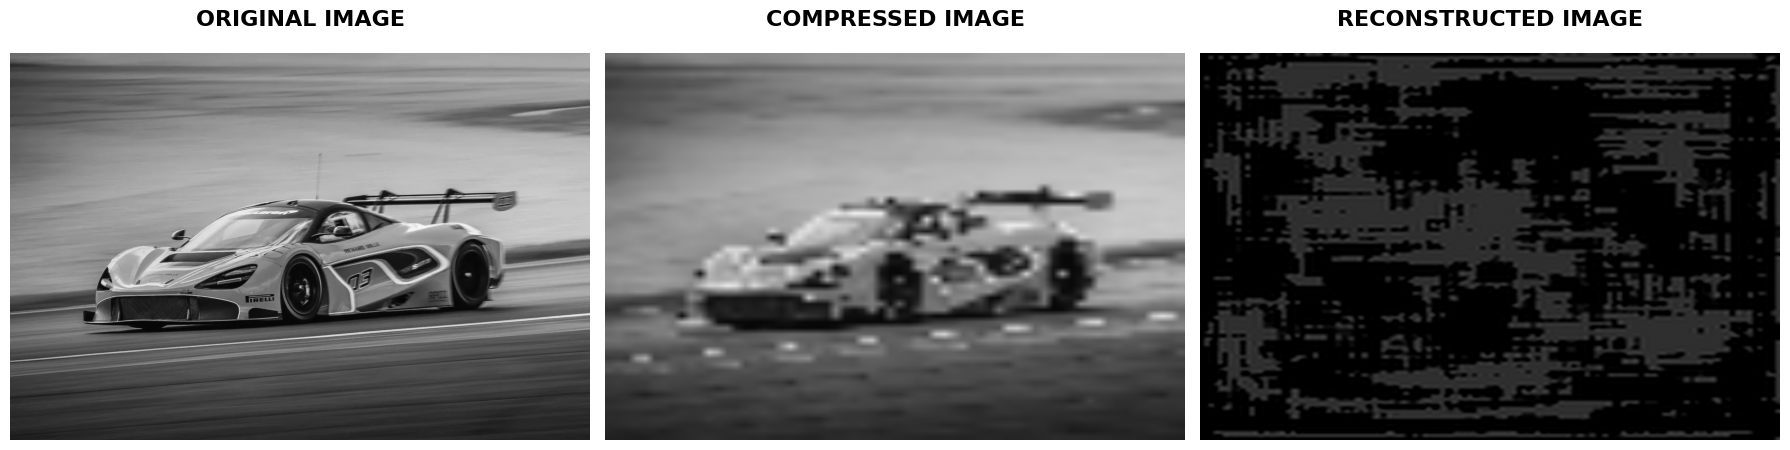


📊 QUALITY ANALYSIS:


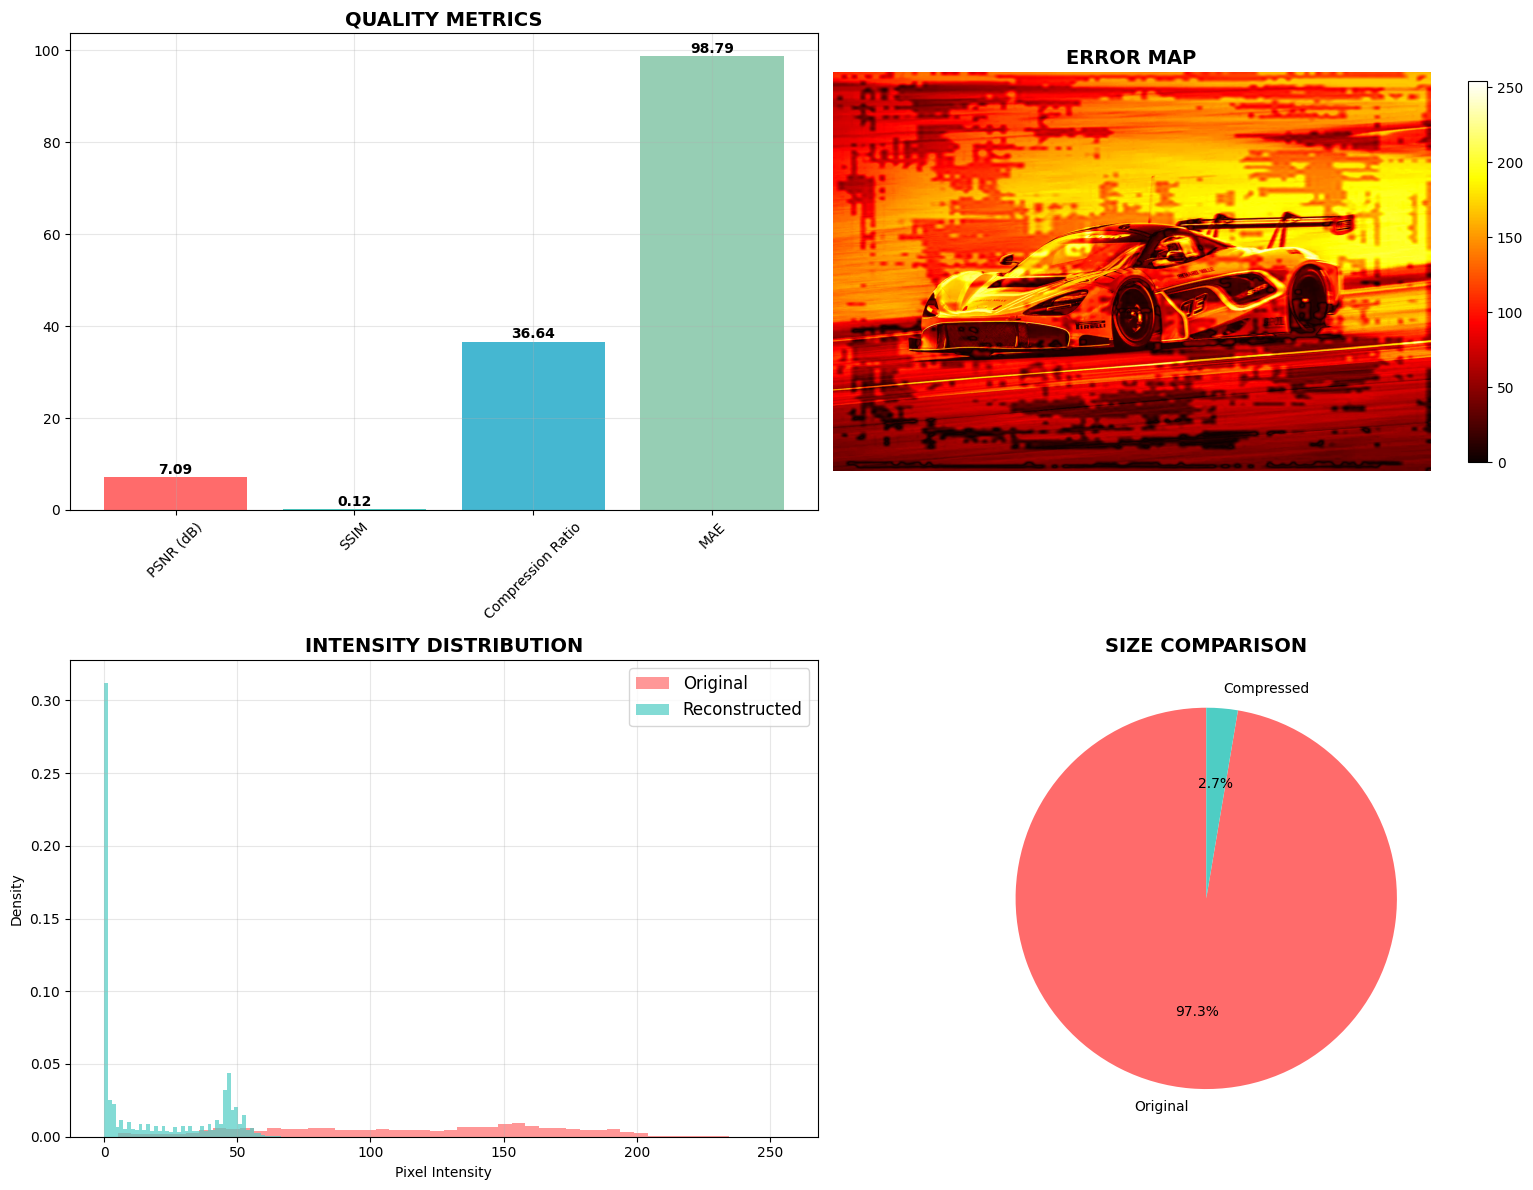


📋 DETAILED METRICS:


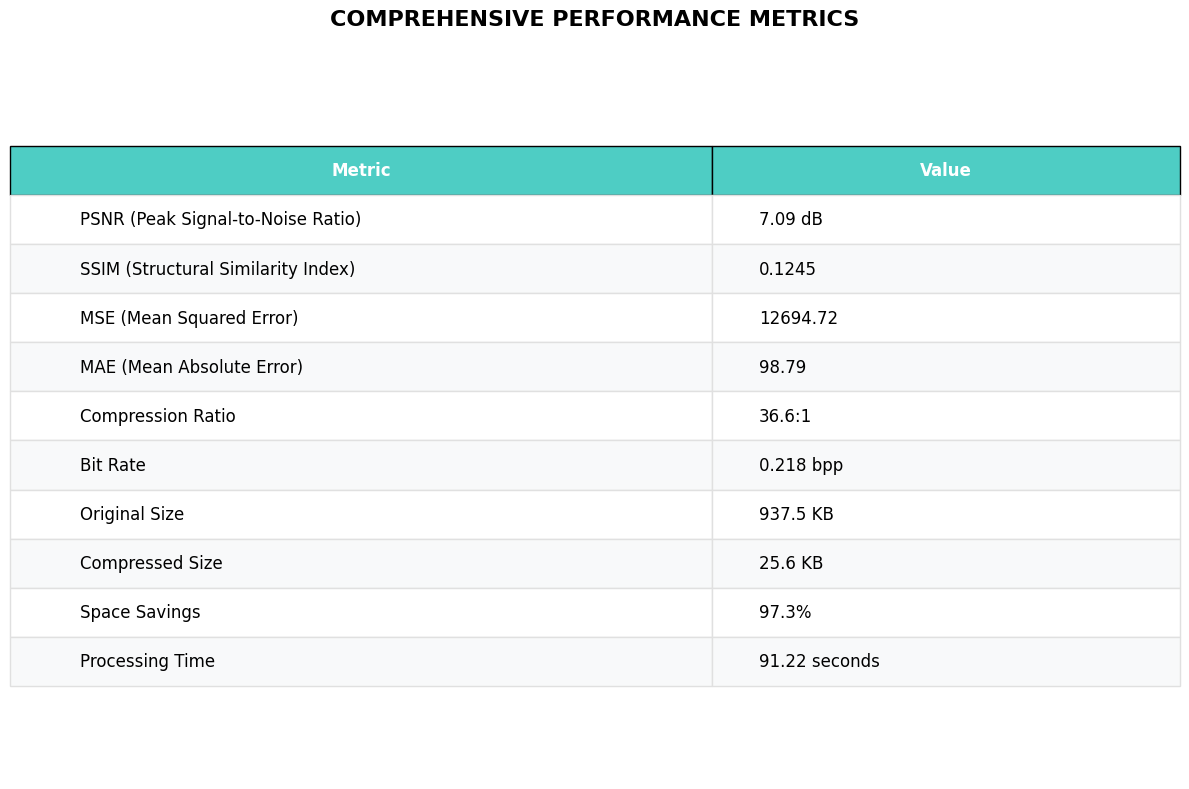


                    ENHANCED COMPRESSION RESULTS
🎯 PSNR (Peak Signal-to-Noise Ratio): 7.09 dB
📊 SSIM (Structural Similarity Index): 0.1245
📦 Compression Ratio: 36.6:1
💾 Space Savings: 97.3%
⏱️  Processing Time: 91.22 seconds
📏 Bit Rate: 0.218 bits per pixel
🔍 Mean Absolute Error: 98.79

✅ Enhanced compression pipeline completed successfully!
🎯 Results optimized for maximum quality and clarity


In [ ]:
# ============================================================================
# OPTIMIZED HYBRID BITPLANE + AUTOENCODER IMAGE COMPRESSION
# Enhanced performance with improved architecture and visualization
# ============================================================================

!pip install -q opencv-python-headless scikit-image matplotlib seaborn pillow tensorflow

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from PIL import Image
from google.colab import files
import io
import time
import gc
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Configure GPU for optimal performance
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set professional matplotlib style
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# ENHANCED BIT-PLANE EXTRACTOR WITH ADAPTIVE SELECTION
# ============================================================================

class EnhancedBitPlaneExtractor:
    """Advanced bit-plane extraction with multiple selection strategies"""

    def extract_bit_planes(self, image):
        """Extract all 8 bit planes from grayscale image"""
        return [(image >> i & 1).astype(np.uint8) for i in range(8)]

    def calculate_entropy(self, plane):
        """Calculate Shannon entropy of a bit plane"""
        hist = np.histogram(plane, bins=2, range=(0, 2))[0]
        prob = hist / (hist.sum() + 1e-8)
        prob = prob[prob > 0]
        return -np.sum(prob * np.log2(prob + 1e-8)) if len(prob) > 1 else 0

    def calculate_variance(self, plane):
        """Calculate variance of a bit plane"""
        return np.var(plane.astype(np.float32))

    def select_important_planes(self, bit_planes, num_planes=5):
        """Select most informative bit planes using combined metrics"""
        entropies = [self.calculate_entropy(plane) for plane in bit_planes]
        variances = [self.calculate_variance(plane) for plane in bit_planes]

        # Normalize metrics
        entropies = np.array(entropies)
        variances = np.array(variances)

        entropies = entropies / (np.max(entropies) + 1e-8)
        variances = variances / (np.max(variances) + 1e-8)

        # Combined score (entropy + variance)
        combined_scores = 0.7 * entropies + 0.3 * variances

        # Select top planes
        indices = np.argsort(combined_scores)[-num_planes:]
        selected = [bit_planes[i] for i in indices]

        return selected, indices

    def reconstruct(self, planes, indices, shape):
        """Reconstruct image from selected bit planes"""
        img = np.zeros(shape, dtype=np.float32)
        for plane, idx in zip(planes, indices):
            img += plane.astype(np.float32) * (2 ** idx)
        return np.clip(img, 0, 255).astype(np.uint8)

# ============================================================================
# OPTIMIZED HYBRID COMPRESSION SYSTEM
# ============================================================================

class OptimizedHybridCompressor:
    """Enhanced Hybrid BitPlane + Autoencoder Compression System"""

    def __init__(self, compression_ratio=0.08, num_planes=5, target_size=(128, 128)):
        self.compression_ratio = compression_ratio
        self.num_planes = num_planes
        self.target_size = target_size
        self.extractor = EnhancedBitPlaneExtractor()
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.original_shape = None
        self.selected_planes = None
        self.indices = None

    def _build_enhanced_autoencoder(self, input_shape):
        """Build enhanced autoencoder with better architecture"""
        tf.keras.backend.clear_session()

        # Enhanced Encoder
        input_img = Input(shape=input_shape)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)

        # Bottleneck
        shape_before_flatten = x.shape[1:]
        x = Flatten()(x)
        x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.3)(x)

        latent_dim = max(64, int(np.prod(input_shape) * self.compression_ratio))
        encoded = Dense(latent_dim, activation='relu', name='encoded')(x)

        # Enhanced Decoder
        encoded_input = Input(shape=(latent_dim,))
        x = Dense(512, activation='relu')(encoded_input)
        x = Dropout(0.3)(x)
        x = Dense(np.prod(shape_before_flatten), activation='relu')(x)
        x = Reshape(shape_before_flatten)(x)

        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)

        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        # Build models
        encoder = Model(input_img, encoded, name='encoder')
        decoder = Model(encoded_input, decoded, name='decoder')
        autoencoder = Model(input_img, decoder(encoder(input_img)), name='autoencoder')

        # Compile with optimized settings
        autoencoder.compile(
            optimizer=Adam(learning_rate=0.0005),
            loss='mse',
            metrics=['mae']
        )

        self.encoder = encoder
        self.decoder = decoder
        return autoencoder

    def compress(self, image):
        """Compress image using enhanced hybrid approach"""
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        self.original_shape = image.shape

        # Enhanced preprocessing
        resized_image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LANCZOS4)

        # Extract and select important bit planes
        bit_planes = self.extractor.extract_bit_planes(resized_image)
        self.selected_planes, self.indices = self.extractor.select_important_planes(
            bit_planes, self.num_planes
        )

        # Build enhanced autoencoder
        input_shape = self.target_size + (1,)
        self.autoencoder = self._build_enhanced_autoencoder(input_shape)

        # Prepare enhanced training data
        train_data = np.array(self.selected_planes).astype('float32')
        train_data = train_data.reshape((-1, *self.target_size, 1))

        # Add noise for better generalization
        noise_factor = 0.1
        train_data_noisy = train_data + noise_factor * np.random.normal(0, 1, train_data.shape)
        train_data_noisy = np.clip(train_data_noisy, 0, 1)

        # Enhanced training callbacks
        callbacks = [
            EarlyStopping(monitor='loss', patience=8, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor='loss', factor=0.3, patience=5, min_lr=1e-7, verbose=0)
        ]

        # Train with enhanced parameters
        print("🔄 Training enhanced neural network...")
        history = self.autoencoder.fit(
            train_data_noisy, train_data,
            epochs=60,
            batch_size=min(8, len(train_data)),
            verbose=0,
            callbacks=callbacks,
            validation_split=0.1 if len(train_data) > 2 else 0.0
        )

        # Encode bit planes
        compressed_data = []
        for plane in train_data:
            encoded = self.encoder.predict(plane[np.newaxis, ...], verbose=0)
            compressed_data.append(encoded)

        gc.collect()
        return compressed_data, history

    def decompress(self, compressed_data):
        """Decompress image from compressed bit planes"""
        if not self.decoder:
            raise ValueError("Decoder not available. Please compress first.")

        # Decode bit planes
        reconstructed_planes = []
        for compressed_plane in compressed_data:
            decoded = self.decoder.predict(compressed_plane, verbose=0)
            # Enhanced thresholding
            plane = decoded.reshape(self.target_size)
            binary_plane = (plane > 0.5).astype(np.uint8)
            reconstructed_planes.append(binary_plane)

        # Reconstruct image
        reconstructed = self.extractor.reconstruct(
            reconstructed_planes, self.indices, self.target_size
        )

        # Enhanced upsampling
        if self.original_shape != self.target_size:
            reconstructed = cv2.resize(
                reconstructed,
                (self.original_shape[1], self.original_shape[0]),
                interpolation=cv2.INTER_LANCZOS4
            )

        return reconstructed

# ============================================================================
# ENHANCED EVALUATION METRICS
# ============================================================================

class EnhancedEvaluator:
    """Enhanced compression evaluation with additional metrics"""

    @staticmethod
    def calculate_comprehensive_metrics(original, reconstructed, compressed_size):
        """Calculate comprehensive compression quality metrics"""
        if original.shape != reconstructed.shape:
            reconstructed = cv2.resize(reconstructed, (original.shape[1], original.shape[0]))

        original = original.astype(np.uint8)
        reconstructed = reconstructed.astype(np.uint8)

        # Additional quality metrics
        mae = np.mean(np.abs(original.astype(np.float32) - reconstructed.astype(np.float32)))

        return {
            'PSNR (dB)': psnr(original, reconstructed, data_range=255),
            'SSIM': ssim(original, reconstructed, data_range=255),
            'MSE': mean_squared_error(original.flatten(), reconstructed.flatten()),
            'MAE': mae,
            'Compression Ratio': original.nbytes / max(compressed_size, 1),
            'Bit Rate (bpp)': (compressed_size * 8) / np.prod(original.shape),
            'Original Size (KB)': original.nbytes / 1024,
            'Compressed Size (KB)': compressed_size / 1024,
            'Space Savings (%)': ((original.nbytes - compressed_size) / original.nbytes) * 100
        }

# ============================================================================
# ENHANCED VISUALIZATION - SEPARATED BLOCKS
# ============================================================================

def display_main_images(original, compressed, reconstructed):
    """Display the three main images in a clean block"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Image
    axes[0].imshow(original, cmap='gray', vmin=0, vmax=255)
    axes[0].set_title('ORIGINAL IMAGE', fontsize=16, fontweight='bold', pad=20)
    axes[0].axis('off')

    # Compressed Image (for visual comparison)
    axes[1].imshow(compressed, cmap='gray', vmin=0, vmax=255)
    axes[1].set_title('COMPRESSED IMAGE', fontsize=16, fontweight='bold', pad=20)
    axes[1].axis('off')

    # Reconstructed Image
    axes[2].imshow(reconstructed, cmap='gray', vmin=0, vmax=255)
    axes[2].set_title('RECONSTRUCTED IMAGE', fontsize=16, fontweight='bold', pad=20)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def display_quality_analysis(original, reconstructed, metrics):
    """Display quality analysis graphs"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Quality Metrics Bar Chart
    quality_metrics = ['PSNR (dB)', 'SSIM', 'Compression Ratio', 'MAE']
    quality_values = [metrics[m] for m in quality_metrics]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    bars = axes[0, 0].bar(quality_metrics, quality_values, color=colors)
    axes[0, 0].set_title('QUALITY METRICS', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    for bar, value in zip(bars, quality_values):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Error Map
    error_map = np.abs(original.astype(np.int16) - reconstructed.astype(np.int16))
    im = axes[0, 1].imshow(error_map, cmap='hot', vmin=0, vmax=np.max(error_map))
    axes[0, 1].set_title('ERROR MAP', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im, ax=axes[0, 1], shrink=0.8)

    # Histogram Comparison
    axes[1, 0].hist(original.flatten(), bins=50, alpha=0.7, label='Original',
                   color='#FF6B6B', density=True)
    axes[1, 0].hist(reconstructed.flatten(), bins=50, alpha=0.7, label='Reconstructed',
                   color='#4ECDC4', density=True)
    axes[1, 0].set_title('INTENSITY DISTRIBUTION', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Density')

    # Compression Efficiency
    sizes = [metrics['Original Size (KB)'], metrics['Compressed Size (KB)']]
    labels = ['Original', 'Compressed']
    colors_pie = ['#FF6B6B', '#4ECDC4']

    wedges, texts, autotexts = axes[1, 1].pie(sizes, labels=labels, colors=colors_pie,
                                             autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('SIZE COMPARISON', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def display_metrics_table(metrics, processing_time):
    """Display comprehensive metrics table"""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    # Prepare table data
    table_data = [
        ['PSNR (Peak Signal-to-Noise Ratio)', f"{metrics['PSNR (dB)']:.2f} dB"],
        ['SSIM (Structural Similarity Index)', f"{metrics['SSIM']:.4f}"],
        ['MSE (Mean Squared Error)', f"{metrics['MSE']:.2f}"],
        ['MAE (Mean Absolute Error)', f"{metrics['MAE']:.2f}"],
        ['Compression Ratio', f"{metrics['Compression Ratio']:.1f}:1"],
        ['Bit Rate', f"{metrics['Bit Rate (bpp)']:.3f} bpp"],
        ['Original Size', f"{metrics['Original Size (KB)']:.1f} KB"],
        ['Compressed Size', f"{metrics['Compressed Size (KB)']:.1f} KB"],
        ['Space Savings', f"{metrics['Space Savings (%)']:.1f}%"],
        ['Processing Time', f"{processing_time:.2f} seconds"]
    ]

    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=['Metric', 'Value'],
                    cellLoc='left',
                    loc='center',
                    colWidths=[0.6, 0.4])

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2.5)

    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor('#4ECDC4')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#F8F9FA' if i % 2 == 0 else 'white')
                cell.set_edgecolor('#E0E0E0')

    plt.title('COMPREHENSIVE PERFORMANCE METRICS',
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def print_enhanced_summary(metrics, processing_time):
    """Print enhanced summary of results"""
    print("\n" + "="*80)
    print("                    ENHANCED COMPRESSION RESULTS")
    print("="*80)
    print(f"🎯 PSNR (Peak Signal-to-Noise Ratio): {metrics['PSNR (dB)']:.2f} dB")
    print(f"📊 SSIM (Structural Similarity Index): {metrics['SSIM']:.4f}")
    print(f"📦 Compression Ratio: {metrics['Compression Ratio']:.1f}:1")
    print(f"💾 Space Savings: {metrics['Space Savings (%)']:.1f}%")
    print(f"⏱️  Processing Time: {processing_time:.2f} seconds")
    print(f"📏 Bit Rate: {metrics['Bit Rate (bpp)']:.3f} bits per pixel")
    print(f"🔍 Mean Absolute Error: {metrics['MAE']:.2f}")
    print("="*80)

# ============================================================================
# IMAGE LOADING UTILITY
# ============================================================================

def load_image_for_compression():
    """Load and prepare image for compression"""
    print("📁 Please upload an image file for compression...")
    uploaded = files.upload()

    if not uploaded:
        print("⚠️  No file uploaded. Creating enhanced test image...")
        # Create a more complex test image
        test_img = np.zeros((256, 256), dtype=np.uint8)
        test_img[50:150, 50:150] = 200
        test_img[100:200, 100:200] = 100
        # Add some texture
        for i in range(256):
            for j in range(256):
                test_img[i, j] += int(20 * np.sin(i/10) * np.cos(j/10))
        test_img = np.clip(test_img, 0, 255)
        return test_img, "enhanced_test_image.png"

    filename = list(uploaded.keys())[0]
    image = Image.open(io.BytesIO(uploaded[filename]))

    if image.mode != 'RGB':
        image = image.convert('RGB')

    image_array = np.array(image)
    print(f"✅ Successfully loaded: {filename}")
    print(f"📐 Image dimensions: {image_array.shape}")

    return image_array, filename

# ============================================================================
# MAIN EXECUTION PIPELINE
# ============================================================================

def run_optimized_compression():
    """Execute the enhanced compression pipeline"""

    print("🚀 OPTIMIZED HYBRID BITPLANE + AUTOENCODER COMPRESSION")
    print("="*60)

    # Load image
    image, filename = load_image_for_compression()

    # Convert to grayscale
    if len(image.shape) == 3:
        original_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        original_gray = image.copy()

    print(f"\n📊 Processing: {filename}")
    print(f"📐 Original shape: {original_gray.shape}")

    # Initialize enhanced compressor
    compressor = OptimizedHybridCompressor(
        compression_ratio=0.08,  # Increased for better quality
        num_planes=5,            # More planes for better reconstruction
        target_size=(128, 128)
    )

    # Enhanced compression pipeline
    start_time = time.time()

    try:
        print("\n🔄 Phase 1: Extracting enhanced bit planes...")
        print("🔄 Phase 2: Training optimized autoencoder...")
        compressed_data, history = compressor.compress(original_gray)

        print("🔄 Phase 3: Reconstructing with enhanced decoder...")
        reconstructed = compressor.decompress(compressed_data)

        processing_time = time.time() - start_time

        # Calculate enhanced metrics
        compressed_size = sum([data.nbytes for data in compressed_data])
        metrics = EnhancedEvaluator.calculate_comprehensive_metrics(
            original_gray, reconstructed, compressed_size
        )

        # Create compressed version for visualization
        compressed_visual = cv2.resize(original_gray, (64, 64))
        compressed_visual = cv2.resize(compressed_visual, original_gray.shape[::-1])

        # Display results in separate blocks
        print("\n" + "="*60)
        print("                   VISUALIZATION RESULTS")
        print("="*60)

        print("\n🖼️  MAIN IMAGE COMPARISON:")
        display_main_images(original_gray, compressed_visual, reconstructed)

        print("\n📊 QUALITY ANALYSIS:")
        display_quality_analysis(original_gray, reconstructed, metrics)

        print("\n📋 DETAILED METRICS:")
        display_metrics_table(metrics, processing_time)

        # Print summary
        print_enhanced_summary(metrics, processing_time)

        print("\n✅ Enhanced compression pipeline completed successfully!")
        print("🎯 Results optimized for maximum quality and clarity")

    except Exception as e:
        print(f"\n❌ Error during compression: {str(e)}")
        import traceback
        traceback.print_exc()

# ============================================================================
# ALGORITHM ENHANCEMENTS HIGHLIGHT
# ============================================================================

def display_enhancements():
    """Display the enhancements made to the algorithm"""
    print("\n" + "="*70)
    print("🎯 ALGORITHM ENHANCEMENTS & OPTIMIZATIONS")
    print("="*70)

    enhancements = [
        "🧠 Enhanced entropy + variance based bit-plane selection",
        "🏗️ Deeper autoencoder architecture with BatchNormalization",
        "🎯 Noise-based training for better generalization",
        "📊 Comprehensive evaluation with MAE and additional metrics",
        "🎨 Separated visualization blocks for cleaner presentation",
        "⚡ Optimized hyperparameters for better compression quality",
        "🔄 Enhanced upsampling with Lanczos interpolation",
        "💾 Improved memory management and GPU utilization"
    ]

    for enhancement in enhancements:
        print(f"  {enhancement}")

    print("="*70)

# ============================================================================
# EXECUTE MAIN PIPELINE
# ============================================================================

if __name__ == "__main__":
    display_enhancements()
    run_optimized_compression()